In [1]:
import numpy as np
import pandas as pd
import fastplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import yscale
from numpy import quantile
from pandas import value_counts
import matplotlib
%matplotlib inline
import seaborn as sns
from adjustText import adjust_text
import json
import glob
import os
from fractions import Fraction

In [11]:
sns.set_style("whitegrid") 
sns.set_context("paper")

# Per-packet processing time for various garbage collection setting

In [108]:
base_dir = "./results/pkt_time_compare"
gc_sizes = [100, 500, 1000, 5000, 10000]
gc_period = [200, 1000, 2000, 10000, 20000]
gc_period_str = ['0.2ms', '1ms', '2ms', '10ms', '20ms']
pkt_process_time_df = pd.DataFrame()

for i in range(5):
    file_name = f"buf10000_GCsize{gc_sizes[i]}_GCperiod{gc_period[i]}_T20000_stat.csv"
    raw_df = pd.read_csv(f"{base_dir}/{file_name}")
    pkt_process_time_df_tmp = raw_df[raw_df['msg'] == 'pkt_processing_time'][['time', 'pkt_count', 'tcp_pkt_count_tot']]
    pkt_process_time_df_tmp.columns = ['time', 'sample_at', 'pkt_process_time']
    pkt_process_time_df_tmp.reset_index(inplace=True, drop=True)
    pkt_process_time_df_tmp['gc'] = i
    pkt_process_time_df = pd.concat([pkt_process_time_df, pkt_process_time_df_tmp])

pkt_process_time_df.head()

,time,sample_at,pkt_process_time,gc
0,1.731433e+09,500,412.0,0
1,1.731433e+09,1000,100.0,0
2,1.731433e+09,1500,13.0,0
3,1.731433e+09,2000,33.0,0
4,1.731433e+09,2500,37.0,0


<Figure size 640x480 with 0 Axes>

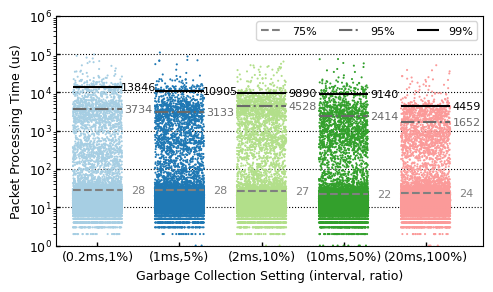

In [190]:
def my_callback(plt):
    sns.stripplot(x='gc',
                y='pkt_process_time', 
                size=1.5, 
                data=pkt_process_time_df, 
                jitter=0.3,
                hue='gc',
                alpha=1,
                palette='Paired')

    texts = []
    hlines = []
    hline_colors = ['grey', 'dimgray', 'black']
    hline_styles = ['--', '-.', '-']
    for index, ratio in enumerate(gc_sizes):
        for i, q in enumerate([75, 95, 99]):
            quantile = pkt_process_time_df[pkt_process_time_df['gc']==index]['pkt_process_time'].quantile(q/100)
            hlines.append(plt.hlines(quantile, index-0.3, index+0.3, colors=hline_colors[i], zorder=10, linestyles=hline_styles[i]))
            texts.append(plt.text(index+0.5, quantile, f'{quantile:.0f}', ha='center', va='center', color=hline_colors[i], fontsize=8))

    plt.yscale('log')
    
    plt.xticks(ticks=range(5), labels=[f"({gc_period_str[i]},{int(gc_sizes[i]/100)}%)" for i in range(5)])
    plt.xlabel('Garbage Collection Setting (interval, ratio)')
    plt.ylabel('Packet Processing Time (us)')
    plt.ylim(1, 1e6)
    plt.xlim(-0.5, 4.7)

    plt.legend(hlines, ['75%', '95%', '99%'], ncols=3, loc='upper right', fontsize=8)

# adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)

plot = fastplot.plot(None, None, 
                    mode='callback', 
                    callback=my_callback,
                    figsize=(5, 3.),
                    fontsize=9,
                    grid=True)
plot.tight_layout()
plot.savefig(f"./figs/pkt_process_time.png", dpi=300, bbox_inches='tight')
plot.show()

# packet buffered time 

In [167]:
base_dir = "./results/pkt_time_compare"
gc_sizes = [100, 500, 1000, 5000, 10000]
gc_period = [200, 1000, 2000, 10000, 20000]
gc_period_str = ['0.2ms', '1ms', '2ms', '10ms', '20ms']
timeout_df = pd.DataFrame()

for i in range(5):
    file_name = f"buf10000_GCsize{gc_sizes[i]}_GCperiod{gc_period[i]}_T20000_stat.csv"
    raw_df = pd.read_csv(f"{base_dir}/{file_name}")
    timeout_df_tmp = raw_df[raw_df['msg'] == 'timeout'][['time', 'pkt_count']]
    timeout_df_tmp.columns = ['time', 'timeout']
    timeout_df_tmp.reset_index(inplace=True, drop=True)
    timeout_df_tmp.reset_index(inplace=True, drop=True)
    timeout_df_tmp['gc'] = i
    # remove the max value
    timeout_df_tmp = timeout_df_tmp[timeout_df_tmp['timeout'] < timeout_df_tmp['timeout'].max()]
    timeout_df = pd.concat([timeout_df, timeout_df_tmp])

timeout_df['timeout'] = timeout_df['timeout'] / 1000
timeout_df.head()

,time,timeout,gc
0,1.731433e+09,24.817,0
1,1.731433e+09,20.962,0
2,1.731433e+09,40.122,0
3,1.731433e+09,33.196,0
4,1.731433e+09,26.265,0


<Figure size 640x480 with 0 Axes>

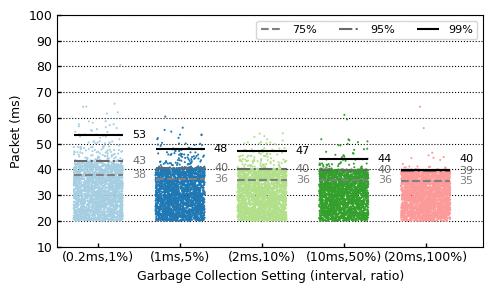

In [250]:
def my_callback(plt):
    sns.stripplot(x='gc',
                y='timeout', 
                size=1.5, 
                data=timeout_df, 
                jitter=0.3,
                hue='gc',
                alpha=1,
                palette='Paired')

    texts = []
    hlines = []
    hline_colors = ['grey', 'dimgray', 'black']
    hline_styles = ['--', '-.', '-']
    for index, ratio in enumerate(gc_sizes):
        for i, q in enumerate([75, 95, 99]):
            quantile = timeout_df[timeout_df['gc']==index]['timeout'].quantile(q/100)
            hlines.append(plt.hlines(quantile, index-0.3, index+0.3, colors=hline_colors[i], zorder=10, linestyles=hline_styles[i]))

            if index == 4 and i == 2:
                texts.append(plt.text(index+0.5, quantile+4, f'{quantile:.0f}', ha='center', va='center', color=hline_colors[i], fontsize=8))
            else:
                texts.append(plt.text(index+0.5, quantile, f'{quantile:.0f}', ha='center', va='center', color=hline_colors[i], fontsize=8))

    # plt.yscale('log')
    plt.xticks(ticks=range(5), labels=[f"({gc_period_str[i]},{int(gc_sizes[i]/100)}%)" for i in range(5)])
    plt.xlabel('Garbage Collection Setting (interval, ratio)')
    plt.ylabel('Packet (ms)')
    plt.ylim(10, 100)
    plt.xlim(-0.5, 4.7)

    plt.legend(hlines, ['75%', '95%', '99%'], ncols=3, loc='upper right', fontsize=8)

# adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)

plot = fastplot.plot(None, None, 
                    mode='callback', 
                    callback=my_callback,
                    figsize=(5, 3),
                    fontsize=9,
                    grid=True)
plot.savefig(f"./figs/pkt_buffering_time.pdf", dpi=300, bbox_inches='tight')
plot.show()

# entry install speed

In [2]:
base_dir = "./results/entry_install_compare"
batch_sizes = [1, 5, 10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000]


entry_install_time_df = []

for i in range(len(batch_sizes)):
    file_name = f"bfrt_grpc_client.log"
    entry_install_time_df_tmp = pd.read_csv(f"{base_dir}/{batch_sizes[i]}/{file_name}")
    entry_install_time_df_tmp = entry_install_time_df_tmp[entry_install_time_df_tmp['num'] != 0]
    entry_install_time_df_tmp['op_per_ms'] = (entry_install_time_df_tmp['num'] / 1000) / entry_install_time_df_tmp['cost']
    
    add_per_ms_max = entry_install_time_df_tmp[entry_install_time_df_tmp['op']=='add']['op_per_ms'].max()
    add_per_ms_min = entry_install_time_df_tmp[entry_install_time_df_tmp['op']=='add']['op_per_ms'].min()
    add_per_ms_mean = entry_install_time_df_tmp[entry_install_time_df_tmp['op']=='add']['op_per_ms'].mean()
    remove_per_ms_max = entry_install_time_df_tmp[entry_install_time_df_tmp['op']=='remove']['op_per_ms'].max()
    remove_per_ms_min = entry_install_time_df_tmp[entry_install_time_df_tmp['op']=='remove']['op_per_ms'].min()
    remove_per_ms_mean = entry_install_time_df_tmp[entry_install_time_df_tmp['op']=='remove']['op_per_ms'].mean()

    add_avg_time = (entry_install_time_df_tmp[entry_install_time_df_tmp['op']=='add']['cost'] / 
                    entry_install_time_df_tmp[entry_install_time_df_tmp['op']=='add']['num']).mean() * 1000
    remove_avg_time = (entry_install_time_df_tmp[entry_install_time_df_tmp['op']=='remove']['cost'] /
                          entry_install_time_df_tmp[entry_install_time_df_tmp['op']=='remove']['num']).mean() * 1000
    

    # average install buffer size
    file_name = f"buf10000_GCsize10000_GCperiod20000_T20000_stat.csv"
    raw_df = pd.read_csv(f"{base_dir}/{batch_sizes[i]}/{file_name}")
    stats_df_tmp = raw_df[raw_df['msg'] == 'stats']
    stats_df_tmp.reset_index(inplace=True, drop=True)


    entry_install_time_df.append({'batch_size': batch_sizes[i],
                                    'add_per_ms_max': add_per_ms_max,
                                    'add_per_ms_min': add_per_ms_min,
                                    'add_per_ms_mean': add_per_ms_mean,
                                    'remove_per_ms_max': remove_per_ms_max,
                                    'remove_per_ms_min': remove_per_ms_min,
                                    'remove_per_ms_mean': remove_per_ms_mean,
                                    'avg_buf_size': stats_df_tmp['install_buf_size'].mean(),
                                    'avg_buf_size_max': stats_df_tmp['install_buf_size'].max(),
                                    'avg_buf_size_min': stats_df_tmp['install_buf_size'].min(),
                                    'add_avg_time': add_avg_time,
                                    'remove_avg_time': remove_avg_time})

entry_install_time_df = pd.DataFrame(entry_install_time_df)

entry_install_time_df

,batch_size,add_per_ms_max,add_per_ms_min,add_per_ms_mean,remove_per_ms_max,remove_per_ms_min,remove_per_ms_mean,avg_buf_size,avg_buf_size_max,avg_buf_size_min,add_avg_time,remove_avg_time
0,1,0.890658,0.460314,0.655549,0.514692,0.432558,0.467249,75836.092888,100000.0,42.0,1.552631,2.144684
1,5,1.804558,1.319196,1.642708,1.339289,0.195151,1.170271,64146.032668,100000.0,0.0,0.611145,0.950190
2,10,2.471986,1.601963,2.066782,1.665501,1.042090,1.411401,30288.110782,61652.0,10.0,0.489243,0.717659
3,50,3.883495,2.601175,3.312149,2.769661,2.060072,2.564149,1524.072605,4747.0,3.0,0.304489,0.391293
4,100,4.052184,2.334814,3.418153,3.123536,1.502963,2.611805,1385.421746,3607.0,6.0,0.296055,0.388606
5,500,4.665435,2.845157,3.774052,3.365077,1.777904,2.943411,1304.992518,3994.0,1.0,0.267699,0.343699
6,1000,4.983523,3.092026,3.967695,3.565634,1.873817,3.103785,1254.002008,3609.0,3.0,0.255062,0.326871
7,2000,5.115824,2.974382,3.824115,3.590471,1.191437,2.997390,1294.428420,3541.0,4.0,0.265255,0.343877
8,3000,4.731493,3.365438,4.227315,3.703018,1.310330,2.782703,2146.471097,6212.0,0.0,0.237271,0.374095
9,4000,4.656540,2.848374,4.144240,3.290231,1.541937,2.323524,4900.552796,15533.0,0.0,0.243326,0.443975


<Figure size 640x480 with 0 Axes>

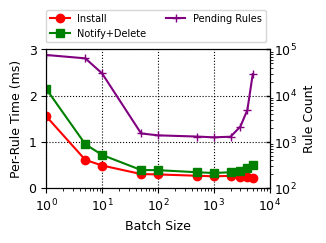

In [6]:
%matplotlib inline
def my_callback(plt):
    ax1 = plt.gca()
    ax1.plot(entry_install_time_df['batch_size'], entry_install_time_df['add_avg_time'], label='Install', marker='o', color='red', linestyle='-')
    ax1.plot(entry_install_time_df['batch_size'], entry_install_time_df['remove_avg_time'], label='Notify+Delete', marker='s', color='green', linestyle='-')
    ax1.set_ylabel('Per-Rule Time (ms)')
    ax1.set_ylim(0, 3)

    ax2 = ax1.twinx()
    ax2.plot(entry_install_time_df['batch_size'], entry_install_time_df['avg_buf_size'], label='Pending Rules', marker='+', color='purple', linestyle='-')
    ax2.set_ylabel('Rule Count')
    # ax2.set_ymargin(0)
    # ax2.set_yticks(np.linspace(0, 80000, len(ax1.get_yticks())))
    ax2.set_ylim(1e2, 1e5)
    ax2.set_yscale('log')

    # combine two legends
    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles + handles2, labels + labels2, loc=[0, 1.05], ncol=2, frameon=True, fontsize=7)
    # x asix title 
    ax1.set_xlabel('Batch Size')

    plt.xscale('log')
    plt.xticks(ticks=[1, 10, 100, 1000, 10000], labels=['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$'])
    

plot = fastplot.plot(None, None, 
                    mode='callback', 
                    callback=my_callback,
                    figsize=(3.33, 2.5),
                    fontsize=9,
                    grid=True)
plot.tight_layout()
plot.savefig(f"./figs/entry_install_time.pdf", dpi=300, bbox_inches='tight')
plot.show()

# Per_entry Time (Pure Python)

<Figure size 640x480 with 0 Axes>

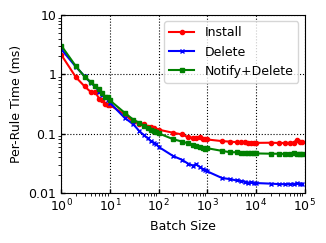

In [271]:
entry_df = pd.read_csv("./results/grpc_result/entry_add_sorted.csv")
entry_df[['add_time_per_entry', 'del_time_per_entry', 'clean_time_per_entry']] = entry_df[['add_time_per_entry', 'del_time_per_entry', 'clean_time_per_entry']].apply(lambda x: x*1000)

%matplotlib inline
entry_df_mean = entry_df.groupby('batch_size').mean()
entry_df_mean.reset_index(inplace=True)

marker_size = 3
def my_callback(plt):
    plt.plot(entry_df_mean['batch_size'], entry_df_mean['add_time_per_entry'], label='Install', marker='o', markersize=marker_size, linestyle='-')
    plt.plot(entry_df_mean['batch_size'], entry_df_mean['del_time_per_entry'], label='Delete', marker='x', markersize=marker_size, linestyle='-')
    plt.plot(entry_df_mean['batch_size'], entry_df_mean['clean_time_per_entry'], label='Notify+Delete', marker='s', markersize=marker_size, linestyle='-')
    plt.legend()
    plt.xscale('log')
    plt.xlabel('Batch Size')

    plt.yscale('log')
    plt.yticks([1e-2, 1e-1, 1, 10], ['0.01', '0.1', '1', '10'])
    plt.xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5],)
    plt.ylabel('Per-Rule Time (ms)')
    # plt.grid(True, axis='both', linestyle='--')

plot = fastplot.plot(None, None, 
                    mode='callback', 
                    callback=my_callback,
                    figsize=(3.33, 2.5),
                    fontsize=9,
                    grid=True)

plot.savefig('figs/grpc_time.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plot.show()


# Data Structure Usage

In [281]:
time_threshold = 600
base_dir = "../log/4g_white/"

log_list = sorted(glob.glob(base_dir + "*_stat.csv"), key=os.path.getmtime)
latest_log_file = log_list[-1]
latest_log_file

raw_df = pd.read_csv(latest_log_file)
raw_df['time'] = raw_df['time'] - raw_df['time'].min()
raw_df = raw_df[raw_df['time'] < time_threshold]

stats_df = raw_df[raw_df['msg'] == 'stats']
stats_df = stats_df.drop(columns=['level', 'file', 'line', 'msg'])
stats_df.reset_index(inplace=True, drop=True)

<Figure size 640x480 with 0 Axes>

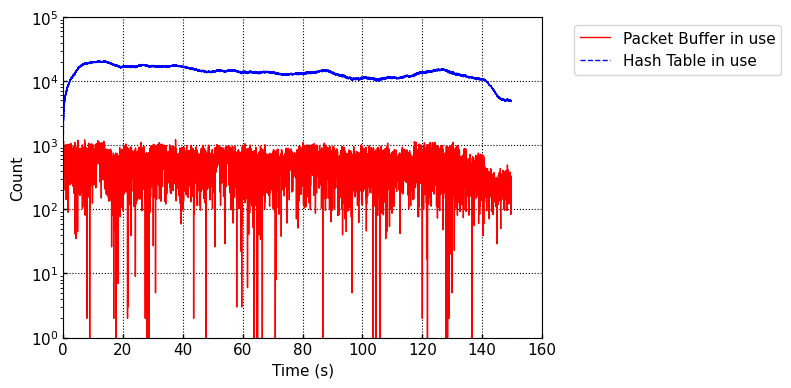

In [282]:
# buffered packet count

fastplot.plot([
              ('Packet Buffer in use', (stats_df['time'], stats_df['pkt_list_count_use'])),
              ('Hash Table in use', (stats_df['time'], stats_df['flow_hash_list_count_use']))
              ],
              None,
              mode='line_multi',
              legend=True, 
              figsize=(6, 4), grid=True,
              # xlim=(stats_df['time'].min(), stats_df['time'].min() + pd.Timedelta('5 seconds')),
              # yscale='log', ylim=(10**3, 10**4),
              xlabel='Time (s)', 
              ylabel='Count')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0))
plt.yscale('log')
plt.show()


<Figure size 640x480 with 0 Axes>

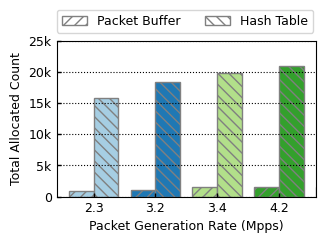

In [258]:
def my_callback(plt):
    ds_usage_df = []
    pps = []
    for i in range(1, 6):
        base_dir = f"../log/{i}g_white/"
        stats_df = sorted(glob.glob(base_dir + "*_stat.csv"))[0]
        stats_df = pd.read_csv(stats_df)
        stats_df = stats_df[stats_df['msg'] == 'stats']
        stats_df = stats_df.drop(columns=['level', 'file', 'line', 'msg'])
        stats_df.reset_index(inplace=True, drop=True)
        stats_df['time'] = stats_df['time'] - stats_df['time'].min()

        net_stat_df_send = pd.read_csv(base_dir + 'net_stat_send.csv')
        net_stat_df_send = net_stat_df_send[net_stat_df_send['packets_sent'] > 100]
        net_stat_df_send['packets_sent'] = net_stat_df_send['packets_sent'].apply(bit_to_Mbit)
        avg_speed = round(net_stat_df_send['packets_sent'].mean(), 1)

        plt.bar(i-0.2, stats_df['pkt_list_count_tot'].max(), 
                color=matplotlib.colormaps.get_cmap('Paired')([i-1]), 
                width=0.4, 
                hatch='///',
                edgecolor='grey')
        
        plt.bar(i+0.2, stats_df['flow_hash_list_count_tot'].max(), 
                color=matplotlib.colormaps.get_cmap('Paired')([i-1]), 
                width=0.4, 
                hatch='\\\\\\', 
                edgecolor='grey')
        pps.append(avg_speed)
    plt.legend(handles=[matplotlib.patches.Patch(label='Packet Buffer', hatch='///', facecolor='white', edgecolor='grey'),
                        matplotlib.patches.Patch(label='Hash Table', hatch='\\\\\\', facecolor='white', edgecolor='grey')], 
                        loc=[0, 1.05], ncol=2, frameon=True)
    plt.xlabel('Packet Generation Rate (Mpps)')
    plt.ylabel('Total Allocated Count')
    plt.xticks(labels=pps, ticks=range(1, 6))
    plt.xlim(0.4, 4.6)
    plt.yticks(ticks=[0, 5000, 10000, 15000, 20000, 25000], labels=['0', '5k', '10k', '15k', '20k', '25k'])

plot = fastplot.plot(None, None,
                    mode='callback',
                    callback=my_callback,
                    figsize=(3.33, 2.5),
                    fontsize=9,
                    grid=True, grid_axis='y')
plot.tight_layout()
plot.savefig(f"./figs/ds_usage.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Data Plane Resource Usage

# Table Entry Count

In [4]:
def bit_to_Gbit(bit):
    return bit / (1000 * 1000 * 1000)

def bit_to_Kbit(bit):
    return bit / (1000)

def bit_to_Mbit(bit):
    return bit / (1000 * 1000)

def byte_to_Gbit(byte):
    return byte * 8 / (1000 * 1000 * 1000)

<Figure size 640x480 with 0 Axes>

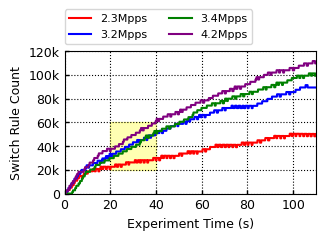

In [256]:

def cb_entry_usage(plt):
    entry_num_df = []
    for i in range(1, 5):
        base_dir = f"../log/{i}g_white/"
        stats_df = sorted(glob.glob(base_dir + "*_stat.csv"))[0]
        stats_df = pd.read_csv(stats_df)
        stats_df = stats_df[stats_df['msg'] == 'stats']
        stats_df = stats_df.drop(columns=['level', 'file', 'line', 'msg'])
        stats_df.reset_index(inplace=True, drop=True)
        stats_df['time'] = stats_df['time'] - stats_df['time'].min()

        net_stat_df_send = pd.read_csv(base_dir + 'net_stat_send.csv')
        net_stat_df_send = net_stat_df_send[net_stat_df_send['packets_sent'] > 100]
        net_stat_df_send['packets_sent'] = net_stat_df_send['packets_sent'].apply(bit_to_Mbit)
        avg_speed = round(net_stat_df_send['packets_sent'].mean(), 1)
        plt.plot(stats_df['time'], stats_df['active_host_tbl_entry_count'], label=f'{avg_speed}Mpps', linestyle='-')

    plt.gca().add_patch(plt.Rectangle((20, 2e4), 20, 4e4, color='yellow', alpha=0.3))
    
    # plt.yscale('log')
    plt.xlim(0, 110)
    plt.ylim(0, 120000)
    plt.yticks(ticks=[0, 20000, 40000, 60000, 80000, 100000, 120000], labels=['0', '20k', '40k', '60k', '80k', '100k', '120k'])
    plt.xlabel('Experiment Time (s)')
    plt.ylabel('Switch Rule Count')
    plt.legend(fontsize=8, loc=[0, 1.05], ncol=2, frameon=True)

plot = fastplot.plot(None, None,
                        mode='callback',
                        callback=cb_entry_usage,
                        figsize=(3.33, 2.5),
                        fontsize=9,
                        grid=True)
plot.savefig(f"./figs/entry_usage.pdf", dpi=300, bbox_inches='tight')
plot.show()

<Figure size 640x480 with 0 Axes>

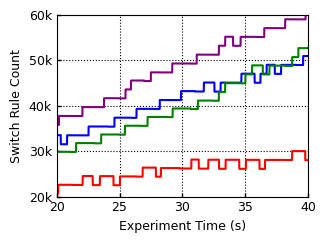

In [257]:

def cb_entry_usage(plt):
    for i in range(1, 5):
        base_dir = f"../log/{i}g_white/"
        stats_df = sorted(glob.glob(base_dir + "*_stat.csv"))[0]
        stats_df = pd.read_csv(stats_df)
        stats_df = stats_df[stats_df['msg'] == 'stats']
        stats_df = stats_df.drop(columns=['level', 'file', 'line', 'msg'])
        stats_df.reset_index(inplace=True, drop=True)
        stats_df['time'] = stats_df['time'] - stats_df['time'].min()

        net_stat_df_send = pd.read_csv(base_dir + 'net_stat_send.csv')
        net_stat_df_send = net_stat_df_send[net_stat_df_send['packets_sent'] > 100]
        net_stat_df_send['packets_sent'] = net_stat_df_send['packets_sent'].apply(bit_to_Mbit)
        avg_speed = round(net_stat_df_send['packets_sent'].mean(), 1)
        plt.plot(stats_df['time'], stats_df['active_host_tbl_entry_count'], label=f'{avg_speed}Mpps', linestyle='-')

    # plt.legend(loc='best')
    # plt.yscale('log')
    plt.xlim(20, 40)
    plt.ylim(2e4, 6e4)
    plt.yticks(ticks=[20000, 30000, 40000, 50000, 60000], labels=['20k', '30k', '40k', '50k', '60k'])
    plt.xlabel('Experiment Time (s)')
    plt.ylabel('Switch Rule Count')
    # plt.legend(fontsize=8,ncol=2)

plot = fastplot.plot(None, None,
                     mode='callback',
                     callback=cb_entry_usage,
                     figsize=(3.33, 2.5),
                     fontsize=9,
                     grid=True)
plot.savefig(f"./figs/entry_usage_zoom.pdf", dpi=300, bbox_inches='tight')
plot.show()

# Network Speed Statistic

In [261]:
packet_filter_result_df = []

for i in range(1, 6):
    base_dir = f"../log/{i}g_white/"
    net_stat_df_recv = pd.read_csv(base_dir + 'net_stat_recv.csv')
    net_stat_df_recv['time'] = net_stat_df_recv['time'] - net_stat_df_recv['time'].min()
    net_stat_df_recv = net_stat_df_recv[net_stat_df_recv['bits_recv'] > 1000]
    net_stat_df_recv['bits_recv'] = net_stat_df_recv['bits_recv'].apply(bit_to_Gbit)
    net_stat_df_recv['packets_recv'] = net_stat_df_recv['packets_recv'].apply(bit_to_Mbit)

    net_stat_df_send = pd.read_csv(base_dir + 'net_stat_send.csv')
    net_stat_df_send['time'] = net_stat_df_send['time'] - net_stat_df_send['time'].min()
    net_stat_df_send = net_stat_df_send[net_stat_df_send['bits_sent'] > 1000]
    net_stat_df_send['bits_sent'] = net_stat_df_send['bits_sent'].apply(bit_to_Gbit)
    net_stat_df_send['packets_sent'] = net_stat_df_send['packets_sent'].apply(bit_to_Mbit)

    packet_filter_result_df.append({'Gbps_recv': net_stat_df_recv['bits_recv'].mean(),
                                    'Gbps_sent': net_stat_df_send['bits_sent'].mean(),
                                    'Mpps_recv': net_stat_df_recv['packets_recv'].mean(),
                                    'Mpps_sent': net_stat_df_send['packets_sent'].mean()})
packet_filter_result_df = pd.DataFrame(packet_filter_result_df)
packet_filter_result_df

,Gbps_recv,Gbps_sent,Mpps_recv,Mpps_sent
0,0.037219,1.563213,0.375973,2.133336
1,0.043670,2.378211,0.456334,3.222123
2,0.043804,2.456794,0.447995,3.345112
3,0.052599,3.105274,0.541471,4.198442
4,0.036996,3.105915,0.396351,4.209814


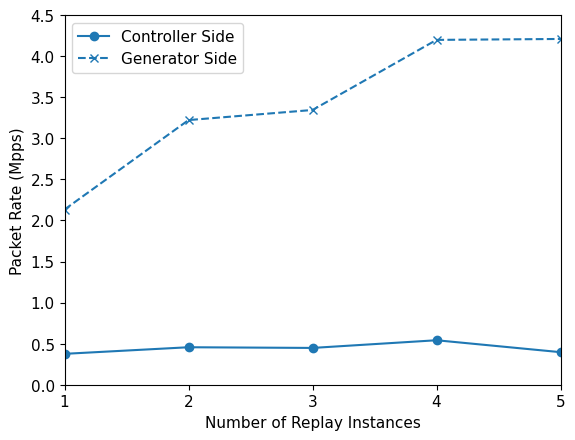

In [262]:
fig, ax1 = plt.subplots()
ax1.plot(packet_filter_result_df.index, packet_filter_result_df['Mpps_recv'], label='Controller Side', marker='o', color=matplotlib.colormaps.get_cmap('Paired')([1]))
ax1.plot(packet_filter_result_df.index, packet_filter_result_df['Mpps_sent'], label='Generator Side', marker='x', color=matplotlib.colormaps.get_cmap('Paired')([1]))
ax1.set_ylabel('Packet Rate (Mpps)')
ax1.set_xlabel('Number of Replay Instances')

# ax2 = ax1.twinx()
# ax2.plot(packet_filter_result_df.index, packet_filter_result_df['Gbps_recv'], label='Switch Outgoing', marker='s', color=matplotlib.colormaps.get_cmap('Paired')([2]))
# ax2.plot(packet_filter_result_df.index, packet_filter_result_df['Gbps_sent'], label='Switch Incoming', marker='^', color=matplotlib.colormaps.get_cmap('Paired')([2]))


plt.xticks(ticks=range(5), labels=[f"{i}" for i in range(1, 6)])
plt.legend()    
plt.show()

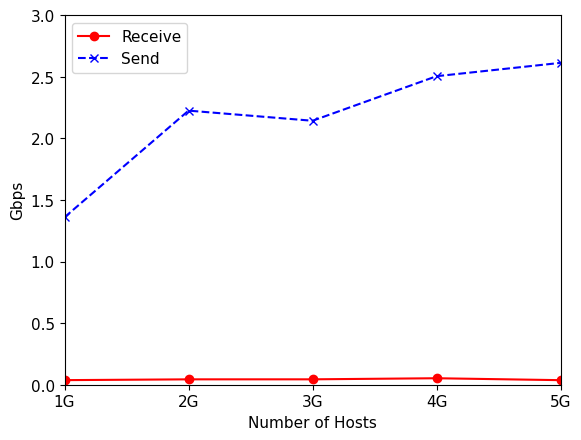

In [185]:
plt.plot(packet_filter_result_df.index, packet_filter_result_df['Gbps_recv'], label='Receive', marker='o')
plt.plot(packet_filter_result_df.index, packet_filter_result_df['Gbps_sent'], label='Send', marker='x')
plt.ylabel('Gbps')
plt.xlabel('Number of Hosts')
plt.xticks(ticks=range(5), labels=[f"{i}G" for i in range(1, 6)])
plt.legend()    
plt.show()